# Lab 0. LeakyReLU

In [2]:
# download the packeges
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

###  0.1 Task

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In [3]:
# Download and prepare CIFAR-10 dataset

transform = transforms.ToTensor()
train_dataset = CIFAR10(root='./cifar-10-batches-py', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./cifar-10-batches-py', train=False, download=True, transform=transform)

print("Train samples:", len(train_dataset), "Test samples:", len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Train samples: 50000 Test samples: 10000


Write a simple CNN network for classifying images
– use LeakyReLU as the activation function (optional)
– use SGD as the optimizer and 0.0001 as the learning rate, and keep all default param-
eters (optional)
– Report the accuracy on the test set (optional)

In [4]:
# Device configuration
device = torch.device("cpu")

In [5]:
# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.0001

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Define a CNN using LeakyReLU activation
class CifarCNN(nn.Module):
    def __init__(self):
        super(CifarCNN, self).__init__()
        self.features = nn.Sequential(
            # First convolution block
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # 3: The number of input channels. For CIFAR-10 images, which are RGB, there are 3 channels.
            # 32: The number of output channels (feature maps). This layer learns 32 different filters.
            # kernel_size=3: The convolution filter has a 3x3 window
            # padding=1: Adds a 1-pixel border around the image
            nn.LeakyReLU(negative_slope=0.01),
            # unlike standard ReLU, allows a small, non-zero gradient when the input is negative.
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel_size=2: The pooling window is 2x2.
            # stride=2: The window moves 2 pixels at a time
            
            # Second convolution block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Converts the multi-dimensional tensor output from the convolutional layers into a one-dimensional vector.
            nn.Linear(64 * 8 * 8, 256),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Linear(256, 10)  # 256 features and CIFAR-10 has 10 classes
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = CifarCNN().to(device)

In [7]:
# Define loss function and optimizer (SGD with learning_rate=0.0001 and default parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [8]:
# Setup TensorBoard writer (logs will be saved in 'runs/sgd_leakyrelu_experiment')
writer = SummaryWriter('runs/sgd_leakyrelu_experiment')

# Lists to record loss and accuracy per epoch (for optional plotting)
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop with evaluation and TensorBoard logging
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_loss_history.append(epoch_train_loss)
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    
    # Evaluation phase
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_loss_history.append(epoch_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
    
    writer.add_scalar('Loss/test', epoch_test_loss, epoch)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

writer.close()

Epoch [1/10], Train Loss: 2.3026, Test Loss: 2.3020, Test Accuracy: 11.53%
Epoch [2/10], Train Loss: 2.3017, Test Loss: 2.3012, Test Accuracy: 11.80%
Epoch [3/10], Train Loss: 2.3009, Test Loss: 2.3004, Test Accuracy: 12.07%
Epoch [4/10], Train Loss: 2.3002, Test Loss: 2.2997, Test Accuracy: 12.39%
Epoch [5/10], Train Loss: 2.2995, Test Loss: 2.2990, Test Accuracy: 12.49%
Epoch [6/10], Train Loss: 2.2988, Test Loss: 2.2983, Test Accuracy: 12.72%
Epoch [7/10], Train Loss: 2.2982, Test Loss: 2.2977, Test Accuracy: 13.15%
Epoch [8/10], Train Loss: 2.2975, Test Loss: 2.2970, Test Accuracy: 14.38%
Epoch [9/10], Train Loss: 2.2969, Test Loss: 2.2964, Test Accuracy: 15.84%
Epoch [10/10], Train Loss: 2.2963, Test Loss: 2.2958, Test Accuracy: 16.86%


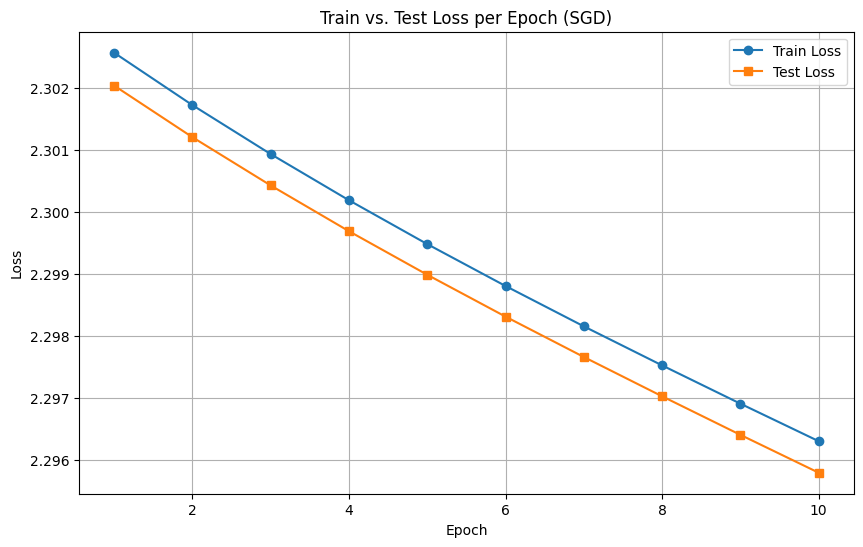

In [9]:
# Plotting Train and Test Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', linestyle='-', label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss_history, marker='s', linestyle='-', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Test Loss per Epoch (SGD)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
# Report final test accuracy
final_accuracy = test_accuracy_history[-1]
print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")


Final Test Accuracy: 16.86%


Run in terminal 

tensorboard --logdir=runs

Change the optimiser to Adam and run again the experiment. Report accuracy on test set.

In [12]:
# Change the optimizer to Adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
# Setup TensorBoard writer (logs will be saved in 'runs/adam_leakyrelu_experiment')
writer = SummaryWriter('runs/adam_leakyrelu_experiment')

# Lists to record loss and accuracy per epoch (for optional plotting)
train_loss_history = []
test_loss_history = []
test_accuracy_history = []

# Training loop with evaluation and TensorBoard logging
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
    
    epoch_train_loss = running_train_loss / len(train_dataset)
    train_loss_history.append(epoch_train_loss)
    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    
    # Evaluation phase
    model.eval()
    running_test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_test_loss = running_test_loss / len(test_dataset)
    test_loss_history.append(epoch_test_loss)
    test_accuracy = 100 * correct / total
    test_accuracy_history.append(test_accuracy)
    
    writer.add_scalar('Loss/test', epoch_test_loss, epoch)
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, "
          f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

writer.close()

Epoch [1/10], Train Loss: 1.8406, Test Loss: 1.5916, Test Accuracy: 44.14%
Epoch [2/10], Train Loss: 1.5329, Test Loss: 1.4498, Test Accuracy: 48.38%
Epoch [3/10], Train Loss: 1.4224, Test Loss: 1.3804, Test Accuracy: 50.83%
Epoch [4/10], Train Loss: 1.3466, Test Loss: 1.3236, Test Accuracy: 52.88%
Epoch [5/10], Train Loss: 1.2904, Test Loss: 1.3010, Test Accuracy: 53.71%
Epoch [6/10], Train Loss: 1.2432, Test Loss: 1.2381, Test Accuracy: 56.67%
Epoch [7/10], Train Loss: 1.2012, Test Loss: 1.1943, Test Accuracy: 57.85%
Epoch [8/10], Train Loss: 1.1699, Test Loss: 1.1710, Test Accuracy: 59.01%
Epoch [9/10], Train Loss: 1.1361, Test Loss: 1.1357, Test Accuracy: 60.47%
Epoch [10/10], Train Loss: 1.1090, Test Loss: 1.1206, Test Accuracy: 60.37%


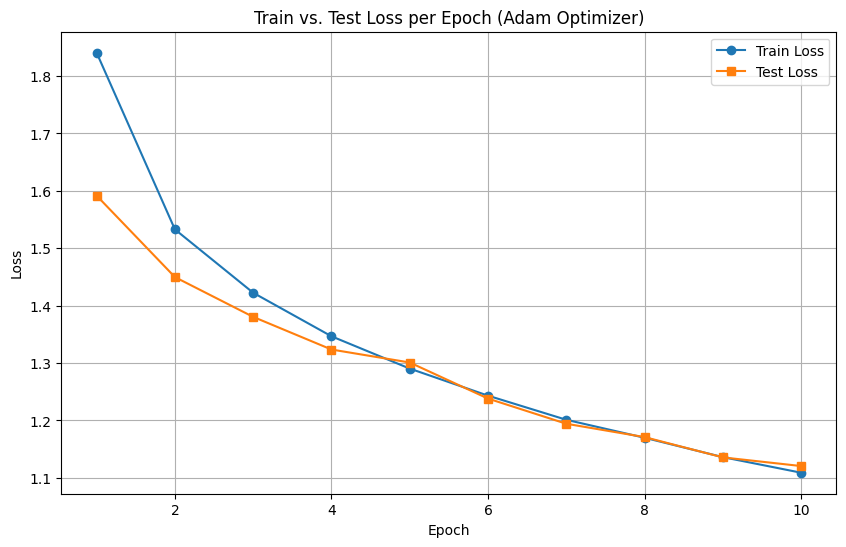

In [14]:
# Plotting Train and Test Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', linestyle='-', label="Train Loss")
plt.plot(range(1, num_epochs + 1), test_loss_history, marker='s', linestyle='-', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs. Test Loss per Epoch (Adam Optimizer)")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
# Report final test accuracy
final_accuracy = test_accuracy_history[-1]
print(f"\nFinal Test Accuracy: {final_accuracy:.2f}%")


Final Test Accuracy: 60.37%


Run in terminal 

tensorboard --logdir=runs

SGD relies on a constant learning rate and follows the gradient descent path uniformly, which can be slow or get stuck in local minima when the error surface is complex.

Adam adapts the learning rates for each parameter by considering the first and second moments of the gradients. This adaptability helps overcome issues such as vanishing gradients and enables the network to converge more rapidly and reach a lower loss.